# Cortical network model

Analysis of 3-population cortical network model with a focus on the effect of the synaptic strength on the network dynamics evoked by a stimulus

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# External imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Internal modules
from logger import logger
from network_model import *
from utils import *
from fileops import get_data_root, get_output_equivalent, load_lineagg_data, save_figs_book
from constants import *
from batchutils import *
from plotters import plot_table, harmonize_axes_limits
from postpro import get_fit_table, get_change_key, get_propagg_keys, compute_predictor

# Initialize empty figures dictionary
figs = {}

# Set up logging folder
logdir = get_output_equivalent(get_data_root(), 'raw', 'model')

### Input data parameters

 2024/04/12 17:10:43: assembling batch analysis settings...


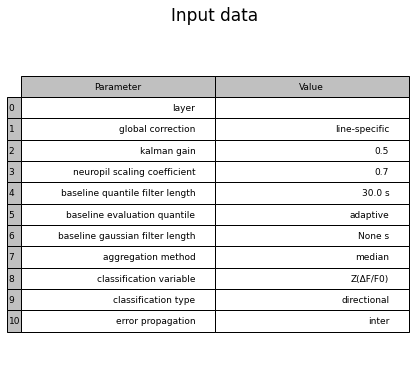

In [3]:
# Parameters determining location of reference activity profiles
analysis_type = 'main' # DEFAULT_ANALYSIS  # Analysis type
layer = None  # cortical layer
global_correction = GLOBAL_CORRECTION  # global stack correction method
kalman_gain = KALMAN_GAIN  # Gain of Kalman filter
neuropil_scaling_coeff = NEUROPIL_SCALING_COEFF  # scaling coefficient for neuropil subtraction
baseline_quantile = BASELINE_QUANTILE  # evaluation quantile for baseline computation
baseline_wquantile = BASELINE_WQUANTILE  # quantile filter window size (s) to compute fluorescence baseline
baseline_wsmoothing = BASELINE_WSMOOTHING  # gaussian filter window size (s) to smooth out fluorescence baseline
trial_aggfunc = TRIAL_AGGFUNC  # trial aggregation function
ykey_classification = YKEY_CLASSIFICATION  # Reference variable for response classification
directional = DIRECTIONAL_DETECTION  # whether to look for directional (i.e. positive only) effect for response detection
errprop = 'inter'

# Get data input directory
_, input_dir, figsdir, _ = get_batch_settings(
    analysis_type, None, layer, global_correction, kalman_gain, neuropil_scaling_coeff,
    baseline_quantile, baseline_wquantile, baseline_wsmoothing,
    trial_aggfunc, ykey_classification, directional)
baseline_quantile_str = 'adaptive' if baseline_quantile is None else f'{baseline_quantile:.2f}'

# Plot dataset info table
figs['dataset_info'] = plot_table({
    'layer': layer,
    'global correction': 'line-specific' if isinstance(global_correction, dict) else global_correction,
    'kalman gain': kalman_gain,
    'neuropil scaling coefficient': neuropil_scaling_coeff,
    'baseline quantile filter length': f'{baseline_wquantile} s',
    'baseline evaluation quantile': baseline_quantile_str,
    'baseline gaussian filter length': f'{baseline_wsmoothing} s',
    'aggregation method': trial_aggfunc.__name__,
    'classification variable': ykey_classification,
    'classification type': f"{'' if directional else 'non '}directional",
    'error propagation': errprop,
    }, title='Input data', aspect=1.5)

### Load data and compute raw response profiles

 2024/04/12 17:10:45: loading line-average data (with inter-propagated SE)
 2024/04/12 17:10:45: loading line3 data from /gpfs/scratch/lemait01/data/usnm/lineagg/aggmedian_classzscore_directional/alpha0.7_qadaptive_wq30.0s/suite2p_fs_3.56_reg_tif_tau_1.25/kd_G0.5_V0.05_npad10/submap_0<-1_9->10every100/main folder
 2024/04/12 17:10:45: loading sst data from /gpfs/scratch/lemait01/data/usnm/lineagg/aggmedian_classzscore_directional/alpha0.7_qadaptive_wq30.0s/suite2p_fs_3.56_reg_tif_tau_1.25/kd_G0.5_V0.05_npad10/submap_0<-1_9->10every100/main folder
 2024/04/12 17:10:45: loading pv data from /gpfs/scratch/lemait01/data/usnm/lineagg/aggmedian_classzscore_directional/alpha0.7_qadaptive_wq30.0s/suite2p_fs_3.56_reg_tif_tau_1.25/kd_G0.5_V0.05_npad10/linreg_robust/submap_0<-1_9->10every100/main folder
 2024/04/12 17:10:45: loading sarah_line3 data from /gpfs/scratch/lemait01/data/usnm/lineagg/aggmedian_classzscore_directional/alpha0.7_qadaptive_wq30.0s/suite2p_fs_3.56_reg_tif_tau_1.25/kd_G0.5_V

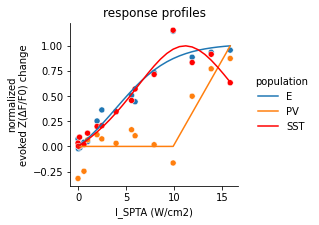

In [4]:
# Load line-aggregated stats
stats, counts = load_lineagg_data(input_dir, errprop=errprop)

# Restrict to 'all' responses
isall = stats.index.get_level_values(Label.ROI_RESP_TYPE) == 'all'
stats = (
    stats[isall]
    .droplevel(Label.ROI_RESP_TYPE)
    .reset_index(Label.RUN, drop=True)
)

# Extract data for responses of interest
xkey = Label.ISPTA
ykey = Label.ZSCORE
ykey_diff = get_change_key(ykey)
ykey_diff_prop = get_propagg_keys(ykey_diff)[0]
resp_data = (
    stats[[Label.ISPTA, ykey_diff_prop]]
    .rename(columns={ykey_diff_prop: ykey_diff})
    .set_index(Label.ISPTA, append=True)
    [ykey_diff]
)

# Fit response data
fit_dict = get_fit_table().loc[xkey]
predictors = {}
for pop, resp in resp_data.groupby(Label.LINE):
    predictors[pop] = compute_predictor(
        resp.droplevel(Label.LINE).index.values, 
        resp.values, 
        fit_dict.loc[pop])

# Compute fit profiles over dense input range
xbounds = np.sort(resp_data.index.unique(xkey))[[0, -1]]
xdense = np.linspace(*xbounds, 25)
resp_profiles = pd.DataFrame(index=pd.Index(xdense, name=xkey))
for pop, pred in predictors.items():
    resp_profiles[pop] = pred(xdense)
resp_profiles = (
    resp_profiles
    .stack()
    .rename_axis(index={None: Label.LINE})
    .swaplevel()
    .sort_index()
    .rename(ykey_diff)
)

# Apply lines->populations mapping
newobjs = []
for s in resp_profiles, resp_data:
    s = s.reset_index(level=Label.LINE)
    s[Label.LINE] = s[Label.LINE].str.replace('line3', 'e').str.upper()
    s['population'] = s.pop(Label.LINE)
    s = s.set_index('population', append=True).swaplevel().sort_index()[ykey_diff]
    newobjs.append(s)
resp_profiles, resp_data = newobjs

# Normalize response data
logger.info('normalizing predictors to [0, 1] range')
resp_bounds = resp_profiles.abs().groupby('population').agg(['min', 'max'])#.droplevel(0, axis=0)
resp_ranges = resp_bounds.diff(axis=1).iloc[:, 1].rename('range')
ykey_diff = f'normalized\n{ykey_diff}'
resp_data = ((resp_data - resp_bounds['min']) / resp_ranges).rename(ykey_diff)
resp_profiles = ((resp_profiles - resp_bounds['min']) / resp_ranges).rename(ykey_diff)

# Plot response profiles
figs['resp_profiles'], ax = plt.subplots(figsize=(3, 3))
sns.despine(ax=ax)
pltkwargs = dict(
    ax=ax,
    x=xkey, 
    y=ykey_diff,
    hue='population',
    palette=NetworkModel.palette,
)
sns.scatterplot(data=resp_data.reset_index(), legend=False, **pltkwargs)
sns.lineplot(data=resp_profiles.reset_index(), **pltkwargs)
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1.05, 0.5), frameon=False)
ax.set_title('response profiles');

### Transform response profiles to network input amplitude space

 2024/04/12 17:10:48: (ISPTA -> amp) conversion factor: 3.00
 2024/04/12 17:10:48: vector ranges
     I_SPTA (W/cm2)  amplitude
min         0.00000   0.000000
max        15.82758  47.482741
 2024/04/12 17:10:49: saving reference profiles to CSV file


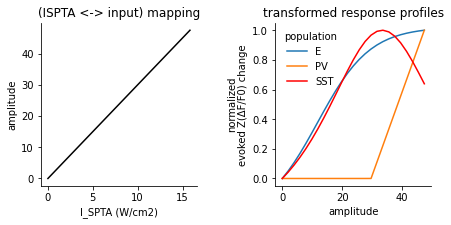

In [5]:
# Define "equivalent" ISPTA and input amplitude doses
ref_ISPTA = 10  # W/cm2
ref_amp = 30  # (-)

# Compute (ISPTA -> amplitude) conversion factor
ISPTA_to_amp = ref_amp / ref_ISPTA  # W/cm2 to (-)
logger.info(f'(ISPTA -> amp) conversion factor: {ISPTA_to_amp:.2f}')

# Compute ISPTA and equivalent input dose vectors
amp_key = 'amplitude'
eqvecs = pd.DataFrame({
    Label.ISPTA: xdense,
    amp_key: xdense * ISPTA_to_amp}
)
logger.info(f'vector ranges\n{eqvecs.agg(["min", "max"])}')

# Compute transformed response profiles in input space
transformed_resp_profiles = resp_profiles.reset_index()
transformed_resp_profiles[amp_key] = transformed_resp_profiles[Label.ISPTA] * ISPTA_to_amp
transformed_resp_profiles = transformed_resp_profiles.set_index(['population', amp_key])[ykey_diff]

# Plot ISPTA - input mapping and transformed response profiles
figs['transformed_resp_profiles'], axes = plt.subplots(1, 2, figsize=(7, 3))
figs['transformed_resp_profiles'].subplots_adjust(wspace=0.5)
for ax in axes:
    sns.despine(ax=ax)
axiter = iter(axes)
ax = next(axiter)
ax.set_title('(ISPTA <-> input) mapping')
sns.lineplot(
    ax=ax,
    data=eqvecs,
    x=Label.ISPTA, 
    y=amp_key,
    color='k'
)
ax = next(axiter)
sns.lineplot(
    ax=ax,
    data=transformed_resp_profiles.reset_index(),
    x=amp_key, 
    y=ykey_diff,
    hue='population',
    palette=NetworkModel.palette,
)
sns.move_legend(ax, loc='upper left', frameon=False)
ax.set_title('transformed response profiles')

# Reference activation profiles
ref_profiles = transformed_resp_profiles.unstack('population')
logger.info('saving reference profiles to CSV file')
ref_fpath = os.path.join(logdir, 'ref_profiles.csv')
if not os.path.exists(ref_fpath):
    ref_profiles.to_csv(ref_fpath)

# Extract input amplitudes from reference profiles
amps = ref_profiles.index.values

## Literature review

### Firing rate adaptation time constants

 2024/04/12 17:10:51: initialized NetworkModel(E, PV, SST)
 2024/04/12 17:10:51: initialized NetworkModel(E, PV, SST)


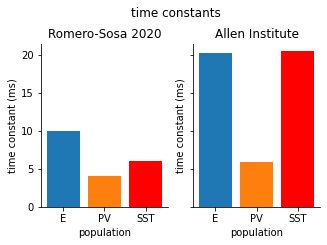

In [6]:
# Time constants (from Romero-Sosa et al. 2020)
tau_romero = pd.Series(
    data={
        'E': 0.010, 
        'PV': .004, 
        'SST': .006,
    },
    name='tau (s)'
)
populations = tau_romero.index

tau_Allen = pd.Series(
    data={
        'E': 0.0202, 
        'PV': 0.0059, 
        'SST': 0.0204,
    },
    name='tau (s)'
)

# Time constants dictionary
tau_dict = {
    'Romero-Sosa 2020': tau_romero,
    'Allen Institute': tau_Allen
}

figs['time constants'], axes = plt.subplots(
    1, len(tau_dict), figsize=(2.5 * len(tau_dict), 3), sharey=True)
figs['time constants'].suptitle('time constants', y=1.05)
for ax, (key, t) in zip(axes, tau_dict.items()):
    NetworkModel(tau=t).plot_time_constants(ax=ax)
    ax.set_title(key)

### Gain functions

 2024/04/12 17:10:52: initialized NetworkModel(E, PV, SST)
 2024/04/12 17:10:53: initialized NetworkModel(E, PV, SST)


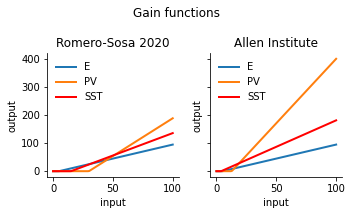

In [7]:
# Gain function: threshold-linear
fgain = threshold_linear

# Gain functions from Romero-Sosa et al. 2020
fparams_romero = pd.DataFrame(
    data={
        'x0': [5, 30, 15],  # E, PV, SST
        'A': [1, 2.7, 1.6], # E, PV, SST
    },
    index=pd.Index(populations, name='population'),
)

# Gain functions from Allen Institute, rescaled to match Romero-Sosa et al. 2020
fparams_Allen = pd.DataFrame(
    data={
        'x0': [5, 12.76, 3.93],  # E, PV, SST
        'A': [1, 4.60, 1.89], # E, PV, SST
    },
    index=pd.Index(populations, name='population'),
)

# Gain function parameters dictionary
fparams_dict = {
    'Romero-Sosa 2020': fparams_romero,
    'Allen Institute': fparams_Allen,
}

figs['fgains'], axes = plt.subplots(
    1, len(fparams_dict), figsize=(2.5 * len(fparams_dict), 3), sharey=True)
figs['fgains'].suptitle('Gain functions')
for ax, (key, fp) in zip(axes, fparams_dict.items()):
    NetworkModel(fgain=fgain, fparams=fp).plot_fgain(ax=ax)
    ax.set_title(key)

### Network connectivity matrices

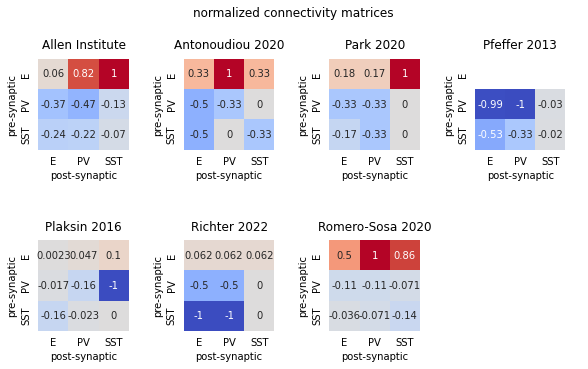

In [8]:
# Connectivity matrix (from Pfeffer et al. 2013)
W_pfeffer = pd.DataFrame(
    data=[
        [np.nan, np.nan, np.nan], # E -> E, PV, SST 
        [-1, -1.01, -0.03],  # PV -> E, PV, SST
        [-0.54, -0.33, -0.02]  # SST -> E, PV, SST
    ], 
    index=pd.Index(populations, name='pre-synaptic'), 
    columns=pd.Index(populations, name='post-synaptic')
)

# Connectivity matrix (from Plaksin et al. 2016)
W_plaksin = pd.DataFrame(
    data=[
        [0.002, 0.04, 0.09],      # E -> E, PV, SST 
        [-0.015, -0.135, -0.86],  # PV -> E, PV, SST
        [-0.135, -0.02, 0]        # SST -> E, PV, SST
    ], 
    index=pd.Index(populations, name='pre-synaptic'), 
    columns=pd.Index(populations, name='post-synaptic')
)

# Connectivity matrix (from Park et al. 2020)
W_park = pd.DataFrame(
    data=[
        [1.1, 1, 6],  # E -> E, PV, SST 
        [-2, -2, 0],  # PV -> E, PV, SST
        [-1, -2, 0]   # SST -> E, PV, SST
    ], 
    index=pd.Index(populations, name='pre-synaptic'), 
    columns=pd.Index(populations, name='post-synaptic')
)

# Connectivity matrix (from Antonoudiou et al. 2020)
W_antonoudiou = pd.DataFrame(
    data=[
        [10, 30, 10],   # E -> E, PV, SST 
        [-15, -10, 0],  # PV -> E, PV, SST
        [-15, 0, -10]   # SST -> E, PV, SST
    ], 
    index=pd.Index(populations, name='pre-synaptic'), 
    columns=pd.Index(populations, name='post-synaptic')
)

# Connectivity matrix (from Romero-Sosa et al. 2020, Figure 6A,B)
W_romero_sosa = pd.DataFrame(
    data=[
        [7, 14, 12],   # E -> E, PV, SST 
        [-1.5, -1.5, -1],  # PV -> E, PV, SST
        [-0.5, -1, -2]   # SST -> E, PV, SST
    ], 
    index=pd.Index(populations, name='pre-synaptic'), 
    columns=pd.Index(populations, name='post-synaptic')
)

# Connectivity matrix (from Richter et al. 2022)
W_richter = pd.DataFrame(
    data=[
        [0.1, 0.1, 0.1],   # E -> E, PV, SST 
        [-0.8, -0.8, 0],  # PV -> E, PV, SST
        [-1.6, -1.6, 0]   # SST -> E, PV, SST
    ], 
    index=pd.Index(populations, name='pre-synaptic'), 
    columns=pd.Index(populations, name='post-synaptic')
)

# Connectivity matrix (from Allen Brain Atlas)
W_allen = pd.DataFrame(
    data=[
        [ 0.06, 0.82, 1.],   # E -> E, PV, SST 
        [-0.37, -0.47, -0.13],  # PV -> E, PV, SST
        [-0.24, -0.22, -0.07],   # SST -> E, PV, SST
    ], 
    index=pd.Index(populations, name='pre-synaptic'), 
    columns=pd.Index(populations, name='post-synaptic')
)

# Assemble into dictionary
Wdict = pd.concat({
    'Pfeffer 2013': W_pfeffer,
    'Plaksin 2016': W_plaksin,
    'Antonoudiou 2020': W_antonoudiou,
    'Park 2020': W_park,
    'Romero-Sosa 2020': W_romero_sosa,
    'Richter 2022': W_richter,
    'Allen Institute': W_allen, 
}, axis=0, names=['source'])

# Comparative plot of connectivity matrices
figs['connectivity comparisons'] = NetworkModel.plot_connectivity_matrix(
    Wdict, norm=True)

## 3-population (E, SST, PV) model

### Define model

 2024/04/13 16:57:47: initialized NetworkModel(E, PV, SST)


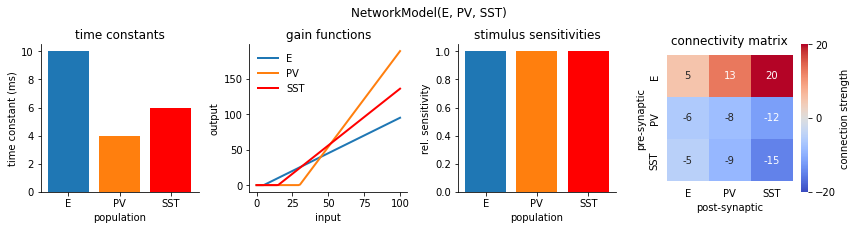

In [72]:
# Connectivity matrix
W = pd.DataFrame(
    data=[
        [5, 13, 20],   # E -> E, PV, SST
        [-6, -8, -12],  # PV -> E, PV, SST
        [-5, -9, -15]   # SST -> E, PV, SST
    ], 
    index=pd.Index(populations, name='pre-synaptic'), 
    columns=pd.Index(populations, name='post-synaptic')
)

# Relative stimulus sensitivities per population
srel = pd.Series(
    1., 
    index=populations,
    name='relative stimulus sensitivity'
)

# Initialize model
model = NetworkModel(
    W=W, 
    tau=tau_romero, 
    fgain=fgain,
    fparams=fparams_romero,
    srel=srel
)

# Plot model summary
figs['model'] = model.plot_summary()    

### Define model evaluation/optimization parameters

In [73]:
norm = True  # whether to normalize activation profiles
disparity_cost_factor = 1e-3 # scaling factor for disparity cost
rel_perturbation = 0.1  # relative perturbations for model sensitivity analysis

### Example simulation and stimulus amplitude sweep

 2024/04/13 16:58:01: NetworkModel(E, PV, SST): running 0.5 s long simulation with A = 6.0
 2024/04/13 16:58:01: simulation completed in 0.031 s
 2024/04/13 16:58:03: running stimulation sweep


100%|██████████| 25/25 [00:00<00:00, 29.30it/s]

 2024/04/13 16:58:04: running stimulation sweep



100%|██████████| 25/25 [00:00<00:00, 29.33it/s]

 2024/04/13 16:58:05: NetworkModel(E, PV, SST): evaluating sensitivity to connectivity perturbations
 2024/04/13 16:58:05: relative perturbation: -10.0%



100%|██████████| 9/9 [00:09<00:00,  1.01s/it]

 2024/04/13 16:58:14: relative perturbation: 10.0%



100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


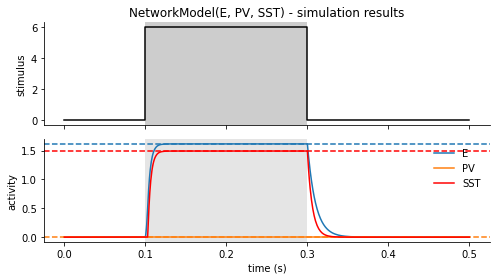

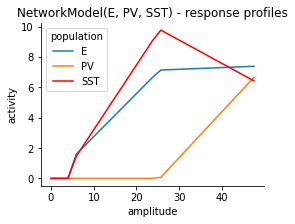

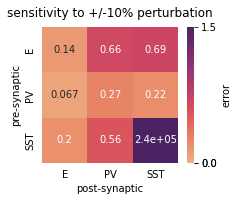

In [74]:
# Define relative amplitudes of external input per population for reference simulations
Athr = model.fparams.loc['E', 'x0']  # E activation threshold
A = 1.2 * Athr

# Simulate model, and extract steady-state stimulus-evoked activity
sol = model.simulate(A=A)
try:
    rss = model.extract_steady_state(sol)
except MetricError as e:
    logger.error(e)
    rss = None

# Plot results
figs['timeseries'] = model.plot_timeseries(sol, ss=rss)

# Simulate model for each amplitude
sweep_data = model.run_stim_sweep(amps)
# Extract steady-state stimulus-evoked activity for each relative amplitude
sweep_rss = model.extract_steady_state(sweep_data)
# Plot steady-state activity dependency on stimulus amplitude
figs['ss dep norm.'] = model.plot_sweep_results(
    sweep_rss, title=f'{model} - response profiles')

# Evaluate sensitivity to network connectivity perturbations
Wsensitivity = model.evaluate_sensitivity(
    amps, rel_perturbation=rel_perturbation, norm=norm, 
    disparity_cost_factor=disparity_cost_factor)
figs['sensitivity'] = model.plot_connectivity_matrix(
    W=Wsensitivity, title=f'sensitivity to +/-{rel_perturbation * 1e2:.0f}% perturbation');

### Explore/optimize connectivity parameters

 2024/04/13 16:58:25: loading optimization results from /gpfs/scratch/lemait01/data/usnm/model/E-PV-SST_threshold_linear_fparams811f5d27f5f880e6a7656fd9236b94d2_tauE0.01PV0.004SST0.006_targets79e907befba8d9f11ceb6bea5923b7f7_diffev_norm_xdisp0.001_rerun4.csv
 2024/04/13 16:58:26: loading optimization results from /gpfs/scratch/lemait01/data/usnm/model/E-PV-SST_threshold_linear_fparams811f5d27f5f880e6a7656fd9236b94d2_tauE0.01PV0.004SST0.006_targets79e907befba8d9f11ceb6bea5923b7f7_diffev_norm_xdisp0.001_rerun3.csv
 2024/04/13 16:58:26: loading optimization results from /gpfs/scratch/lemait01/data/usnm/model/E-PV-SST_threshold_linear_fparams811f5d27f5f880e6a7656fd9236b94d2_tauE0.01PV0.004SST0.006_targets79e907befba8d9f11ceb6bea5923b7f7_diffev_norm_xdisp0.001_rerun2.csv
 2024/04/13 16:58:26: loading optimization results from /gpfs/scratch/lemait01/data/usnm/model/E-PV-SST_threshold_linear_fparams811f5d27f5f880e6a7656fd9236b94d2_tauE0.01PV0.004SST0.006_targets79e907befba8d9f11ceb6bea5923b7f

100%|██████████| 25/25 [00:00<00:00, 32.79it/s]


 2024/04/13 16:58:31: running stimulation sweep


100%|██████████| 25/25 [00:00<00:00, 31.15it/s]


 2024/04/13 16:58:33: running stimulation sweep


100%|██████████| 25/25 [00:00<00:00, 32.17it/s]


 2024/04/13 16:58:35: running stimulation sweep


100%|██████████| 25/25 [00:00<00:00, 32.19it/s]


 2024/04/13 16:58:38: running stimulation sweep


100%|██████████| 25/25 [00:00<00:00, 31.65it/s]


 2024/04/13 16:58:41: running stimulation sweep


100%|██████████| 25/25 [00:00<00:00, 31.83it/s]

 2024/04/13 16:58:42: NetworkModel(E, PV, SST): evaluating sensitivity to connectivity perturbations


 2024/04/13 16:58:42: relative perturbation: -10.0%


100%|██████████| 9/9 [00:08<00:00,  1.08it/s]

 2024/04/13 16:58:50: relative perturbation: 10.0%



100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


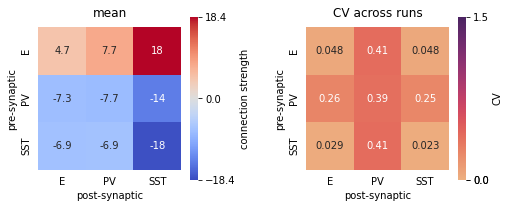

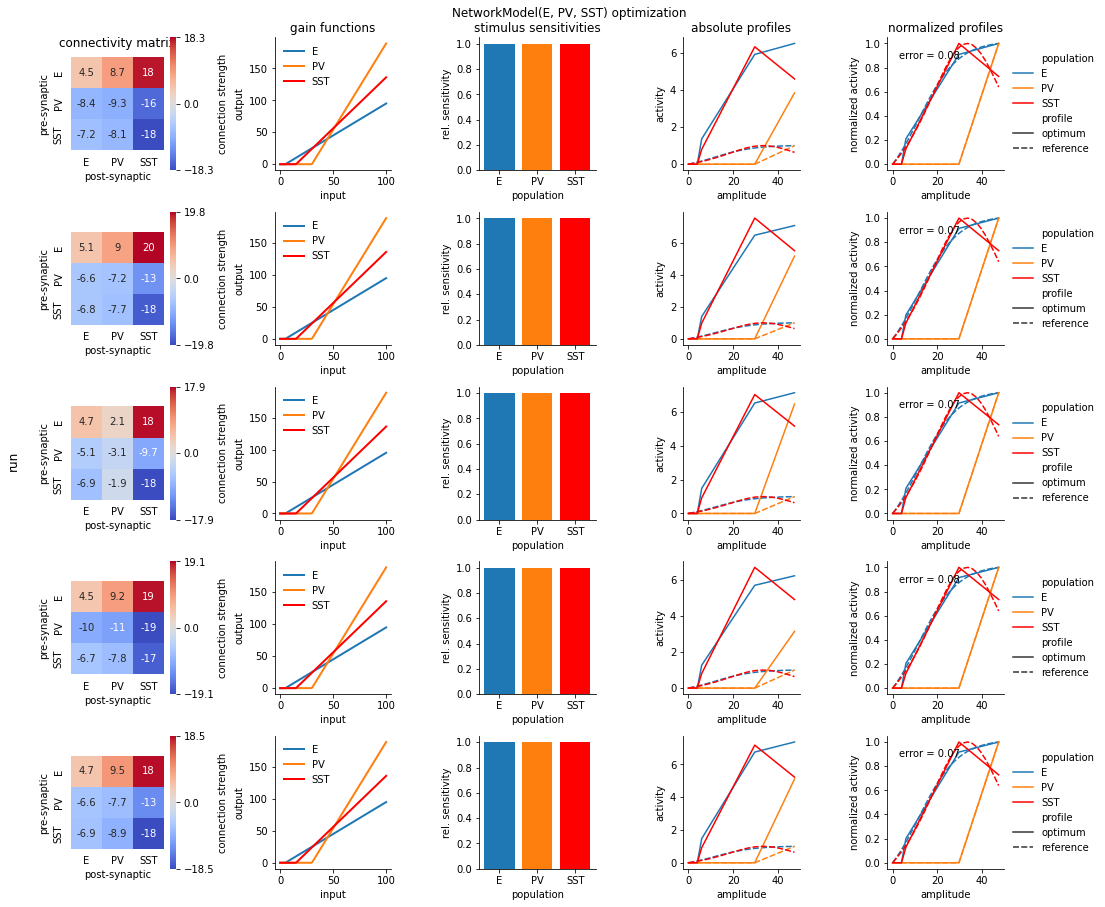

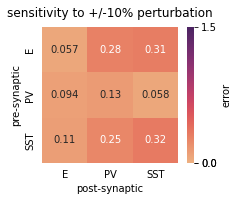

In [75]:
# Adjust gains
# fparams_uniform = model.fparams.copy()
# for k in fparams_uniform.index:
#     fparams_uniform.loc[k] = fparams_uniform.loc['E']
# model.fparams = fparams_uniform


# Set constraints on connectivity matrix
# Wbounds = model.get_coupling_bounds()
# Wbounds.loc['SST', 'SST'] = (0, 0)
# Wbounds = model.get_coupling_bounds(wmax=10)
Wbounds = None

# Define relative stimulus sensitivity exploration bounbs
model.srel = None
# srel_bounds = (0, 1)
# model.srel = pd.Series(
#     {'E': 1., 'PV': 0.2, 'SST': 1.}, 
#     name='stimulus sensitivity'
# )
srel_bounds = None

# Define optimization parameters
optargs, optkwargs = (
    [model, ref_profiles],
    dict(
        norm=norm, 
        disparity_cost_factor=disparity_cost_factor,
        logdir=logdir,
        mpi=True,
        Wbounds=Wbounds,
        srel_bounds=srel_bounds,
    )
)

# # Optimize connectivity matrix to minimize divergence with reference profiles
# W3opt = ModelOptimizer.optimize(*optargs, **optkwargs)

# Load and plot optimization history
histories = ModelOptimizer.load_optimization_history(*optargs, **optkwargs)
if 'run' not in histories.index.names:
    histories = pd.concat({0: histories}, names=['run'])
has_converged = ModelOptimizer.has_optimization_converged(histories)
for irun, converged in has_converged.items():
    if not converged:
        logger.warning(f'optimization did not converge for run {irun}')

# Extract optimum connectivity matrix from each run and associated cost
optimums = ModelOptimizer.extract_optimum(histories)
opt_Wvecs = optimums.apply(lambda x: x[:model.nW])
opt_srelvecs = optimums.apply(lambda x: x[model.nW:])
has_srel = len(opt_srelvecs.iloc[0]) > 0
if has_srel:
    srelopts = pd.DataFrame(opt_srelvecs.to_list(), columns=populations, index=opt_srelvecs.index)
Wopts = model.Wvec_to_Wmat(opt_Wvecs)

# Plot similarity between connectivity matrices from different runs
figs['Wopt convergence'] = model.plot_connectivity_matrix(Wopts, agg=True)

# Create figure
figkey = 'opt results'
nruns = len(optimums)
ncols = 5
figs[figkey], axes = plt.subplots(nruns, ncols, figsize=(3 * ncols, 2.5 * nruns))
axes = np.atleast_2d(axes)

# For each run, perform stimulus sweep with optimal connectivity matrix
for irow, (axrow, (irun, W3opt)) in enumerate(zip(axes, Wopts.groupby('run'))):
    W3opt = W3opt.droplevel('run')
    model.W = W3opt

    if has_srel:
        model.srel = srelopts.loc[irun].rename('stimulus sensitivity')
    sweep_data = model.run_stim_sweep(amps)
    sweep_rss = model.extract_steady_state(sweep_data)

    # Compare results to reference profiles
    cost = model.evaluate_stim_sweep(
        ref_profiles, sweep_data, norm=norm, disparity_cost_factor=disparity_cost_factor)
    sweep_comp = pd.concat({
        'optimum': sweep_rss,
        'reference': ref_profiles
    }, axis=0, names=['profile'])

    # Plot results
    axtitle = None if irow == 0 else ''
    model.plot_connectivity_matrix(W=W3opt, ax=axrow[0], title=axtitle)
    model.plot_fgain(ax=axrow[1], title=axtitle)
    model.plot_stimulus_sensitivity(ax=axrow[2], title=axtitle)
    for ax, n in zip(axrow[3:], [False, True]):
        model.plot_sweep_results(sweep_comp, norm=n, ax=ax, style='profile')
        if irow == 0:
            ax.set_title(f'{"normalized" if n else "absolute"} profiles')
        if not n:
            ax.get_legend().remove()
        if n == norm:
            ax.text(0.1, 0.9, f'error = {cost:.2f}', transform=ax.transAxes, ha='left', va='top')
    sns.move_legend(ax, bbox_to_anchor=(1, .5), loc='center left', frameon=False)

# Harmonize axes limits for absolute profiles
harmonize_axes_limits(axes[:, 1], 'y')

# Adjust layout
figs[figkey].tight_layout()
figs[figkey].supylabel('run', x=-0.02)
figs[figkey].subplots_adjust(wspace=.75)
figs[figkey].suptitle(f'{model} optimization', y=1 + 0.02 / nruns)

# Evaluate sensitivity to network connectivity perturbations
model.W = Wopts.groupby('pre-synaptic').mean()
if has_srel:
    model.srel = srelopts.mean(axis=0)
Wsensitivity = model.evaluate_sensitivity(
    amps, rel_perturbation=rel_perturbation, norm=norm, disparity_cost_factor=disparity_cost_factor)
figs['opt sensitivity'] = model.plot_connectivity_matrix(
    W=Wsensitivity, title=f'sensitivity to +/-{rel_perturbation * 1e2:.0f}% perturbation');

### Save figures

In [13]:
figs = {k: v for k, v in figs.items() if v is not None}
save_figs_book(figsdir, figs, suffix='network_model')

 2024/04/12 17:12:03: saving figures in /gpfs/scratch/lemait01/data/usnm/figs/2024.04.12/figs_network_model.pdf:


100%|██████████| 13/13 [00:04<00:00,  2.60it/s]
